# Setup

In [331]:
# main.py
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import globals as gl
import factory
import pandas as pd

'''Validating data and create plots'''

gl.init()
# factory.Filter.remove_movement_tutorials()
# factory.Filter.remove_shield_tutorial()

dataframes = gl.dataframes
conc_dataframes = gl.conc_dataframes
plt.tight_layout()

# Barplot: Playing time per user and round

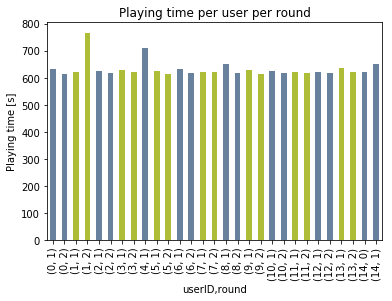

In [332]:
'''Plot: Playing time per user 
'''
plt.ylabel('Playing time [s]')
plt.title('Playing time per user per round')
colors = factory.get_colors()

time_df = conc_dataframes.groupby(['userID', 'round'])['Time'].max()
time_df.plot.bar(color=factory.get_colors())
plt.savefig(gl.svn_base_path + '/Plots/playing_time_per_user.pdf')

- Lengths are more or less the same, with 613s being the shortest, 766s being the longest

# Plot: Average HR over all games

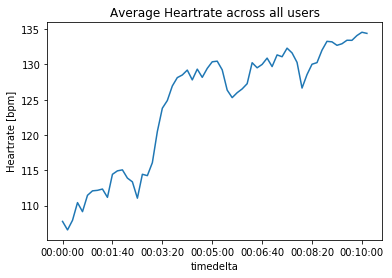

In [333]:
'''Plot: Average Heartrate 
'''


plt.figure()
plt.ylabel('Heartrate [bpm]')
plt.xlabel('Playing time [s]')
plt.title('Average Heartrate across all users')

resolution = 10 # resample every x seconds -> the bigger, the smoother

min_time = time_df.min()
conc_with_hr = conc_with_hr[conc_with_hr['Time']<min_time] # Cut all dataframes to the same minimal length
df_copy = conc_with_hr.copy() # to prevent SettingWithCopyWarning
avg_hr_df = df_copy.groupby(['timedelta'])['Heartrate'].mean() # Take mean over all logfiles
avg_hr_df_resampled = avg_hr_df.resample(str(resolution)+'S').mean() # Resample series

avg_hr_df_resampled.plot()
plt.savefig(gl.svn_base_path + '/Plots/average_heartrate.pdf')

# Boxplot: Mean and std HR 

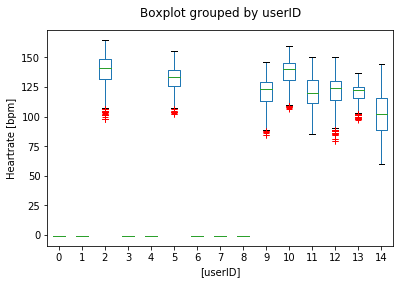

In [334]:
'''Plot: Mean and std bpm per user in a box-chart
'''

df2 = conc_dataframes.pivot(columns=conc_dataframes.columns[1], index=conc_dataframes.index)
df2.columns = df2.columns.droplevel()
conc_dataframes[['Heartrate','userID']].boxplot(by='userID', grid=False, sym='r+')
plt.ylabel('Heartrate [bpm]')
plt.title('')
plt.savefig(gl.svn_base_path + '/Plots/mean_heartrate_boxplot.pdf')

- 8 out of 14 users have HR data

# Barplot: Heartrate Change

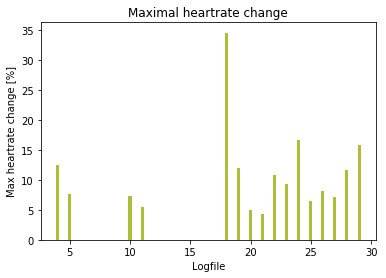

In [335]:
''' Plot Heartrate change
    TODO: Average the two rounds per user!
'''
bpm_changes_max = []  # Stores max. absolute change in HR per logfile 
bpm_changes_rel = [] # Stores max. percentage change in HR per logfile 
X = []
for idx, df in enumerate(dataframes):
    if not (df['Heartrate'] == -1).all():
        X.append(idx)
        percentage_change = np.diff(df['Heartrate']) / df['Heartrate'][:-1] * 100.
        bpm_changes_max.append(percentage_change.max())
        bpm_changes_rel.append(percentage_change)

# plt.ylabel('#Times HR changed')
# plt.xlabel('Change in Heartrate [%]')
# for idx, l in enumerate(bpm_changes_rel):
    # plt.figure()
    # plt.title('Heartrate change for plot' + str(idx))
    # plt.hist(l, color=gl.green_color)
    # plt.savefig(gl.svn_base_path + '/Plots/Heartrate Histograms/heartrate_change_percentage' + str(idx) + '.pdf')


plt.figure()
plt.title('Maximal heartrate change')
plt.ylabel('Max heartrate change [%]')
plt.xlabel('Logfile')
plt.bar([x for x in X], bpm_changes_max, color=gl.green_color, width=0.25)
plt.savefig(gl.svn_base_path + '/Plots/heartrate_change_abs.pdf')

- Most of the logfiles don't have unusual behavior uf the HR, menaing a maximal change of <20% between consecutive measurements 

# Helper Function: Sth. correlated with Difficulty

In [336]:
from matplotlib.ticker import MaxNLocator
def difficulty_corr_plot(toCompare):
    resolution = 5 # resample every x seconds -> the bigger, the smoother
    for idx, df in enumerate(dataframes):
        if not (df['Heartrate'] == -1).all():
            X.append(idx)
            df = dataframes[idx]


            df_num = factory.transformToNumbers(df) # Transform Difficulties into integers
            time_hr = df_num[['timedelta', toCompare, 'physDifficulty']]
            time_hr.set_index('timedelta', inplace=True) #set timedelta as new index
            df_num_resampled = time_hr.resample(str(resolution)+'S').mean() # Resample series
            # Plot Heartrate
            fig, ax1 = plt.subplots()
            ax1.plot(df_num_resampled.index.values, df_num_resampled[toCompare], gl.blue_color)
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel(toCompare, color=gl.blue_color)
            ax1.tick_params('y', colors=gl.blue_color)
            # Plot Difficulty 
            ax2 = ax1.twinx()
            ax2.plot(df_num_resampled.index.values, df_num_resampled['physDifficulty'], gl.green_color)
            ax2.set_ylabel('physDifficulty', color=gl.green_color)
            ax2.tick_params('y', colors=gl.green_color)
            ax2.yaxis.set_major_locator(MaxNLocator(integer=True)) # Only show whole numbers as difficulties

            plt.savefig(gl.svn_base_path + '/Plots/'+toCompare+' Difficulty Corr/'+toCompare+'_difficulty_' +gl.rel_files[idx] + '.pdf')


# Plot: Heartrate correlated with Difficulty

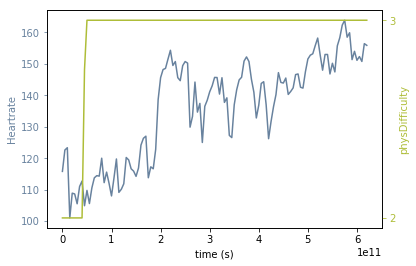

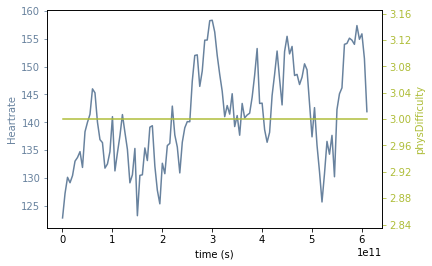

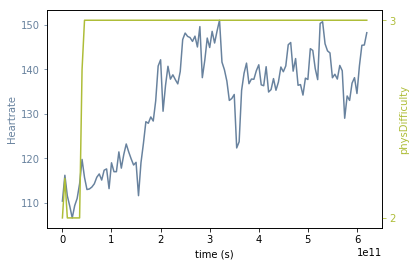

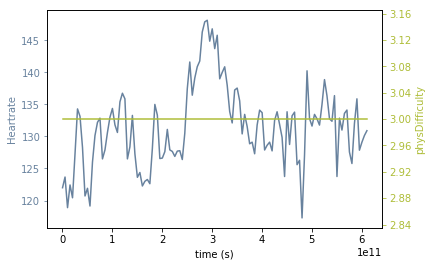

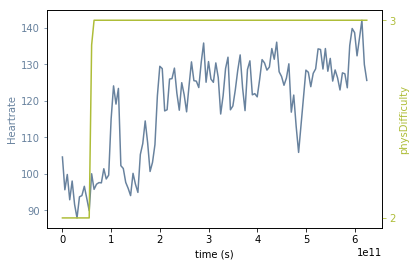

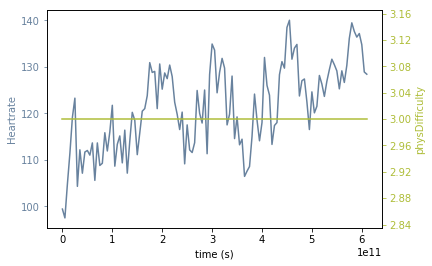

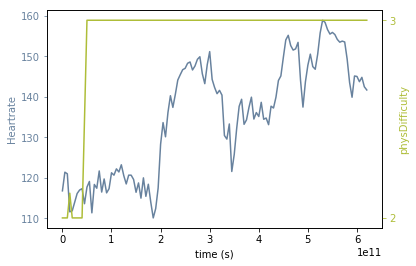

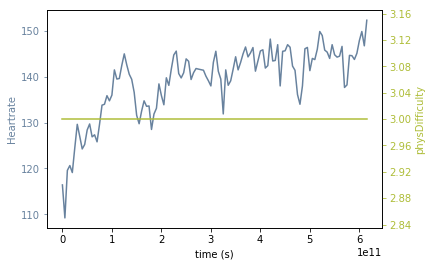

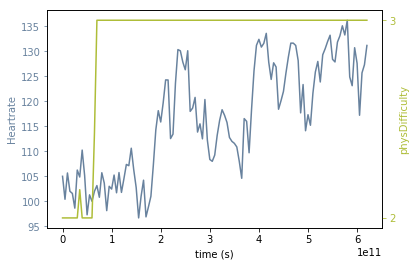

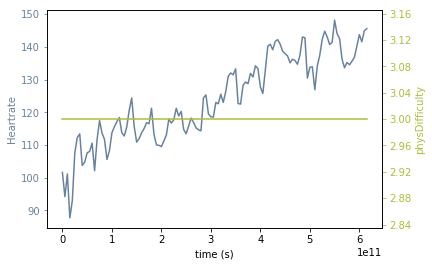

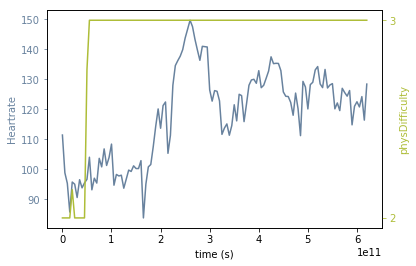

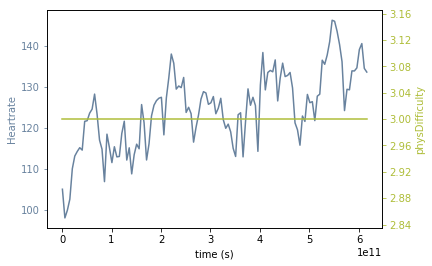

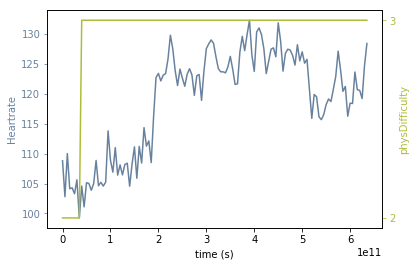

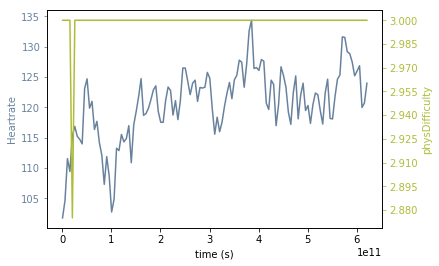

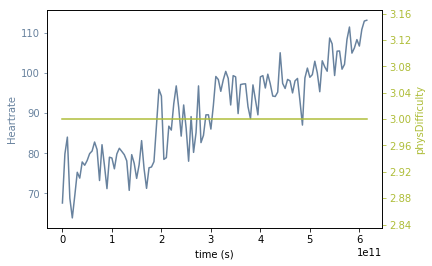

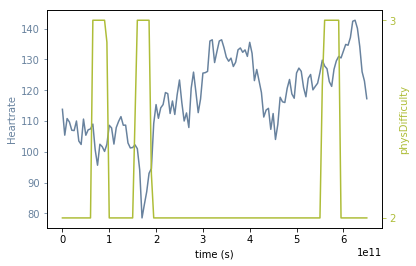

In [337]:
difficulty_corr_plot('Heartrate')

- Not a lot of difficulty changes unfortunately
- A small correlation

# Plot: Points correlated with Difficulty

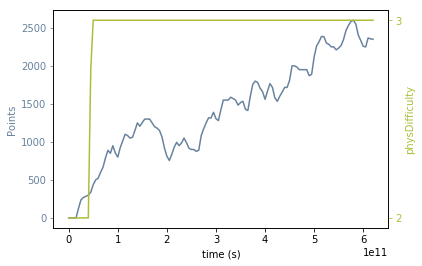

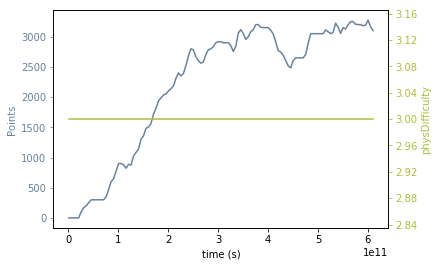

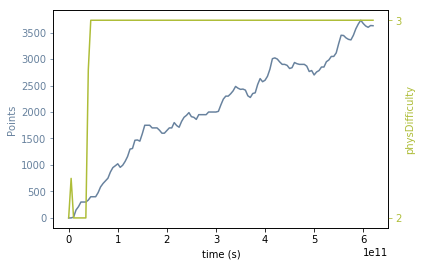

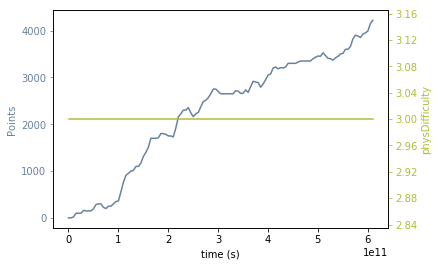

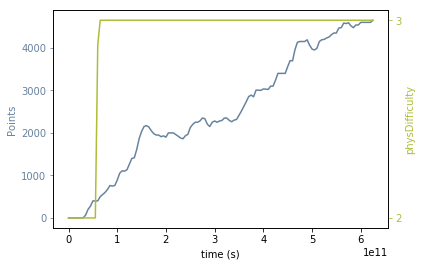

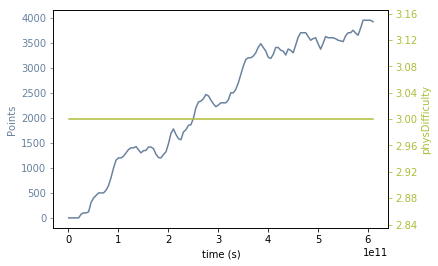

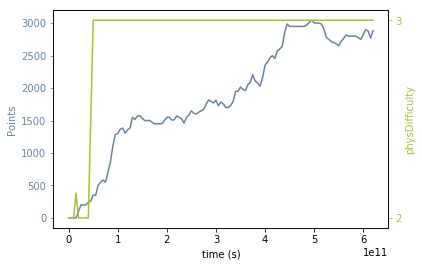

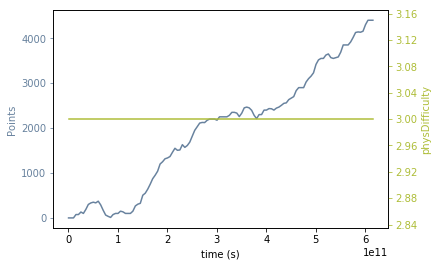

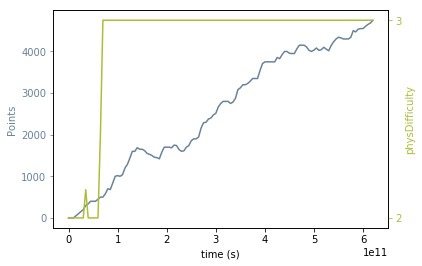

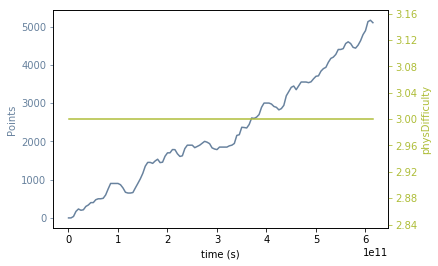

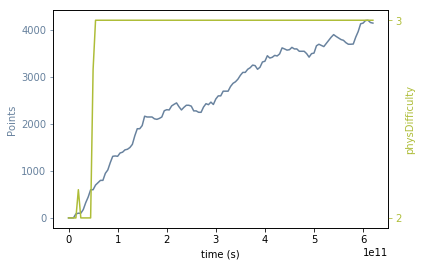

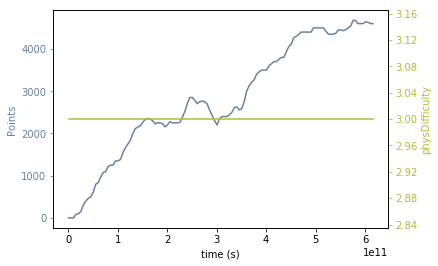

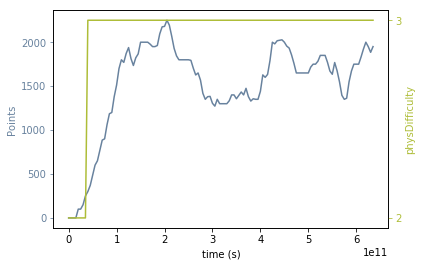

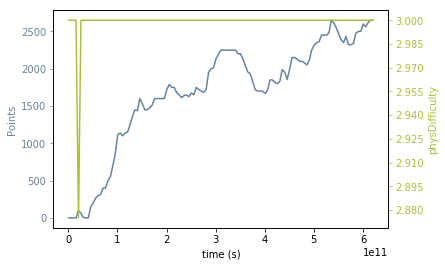

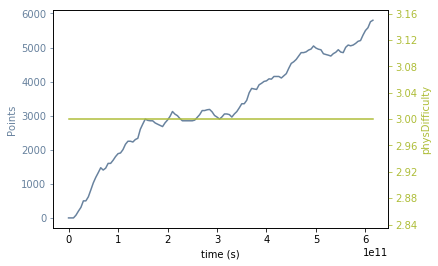

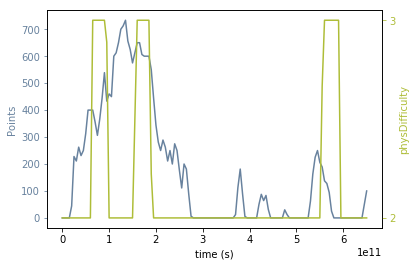

In [338]:
difficulty_corr_plot('Points')

# Scatter plot: Difficulty vs. size of obstacles 

physDifficulty  numObstacles
2               0                2599
                1                 143
                3                 581
                4                  25
3               0               19813
                1                2659
                3                 299
                4                5589
dtype: int64


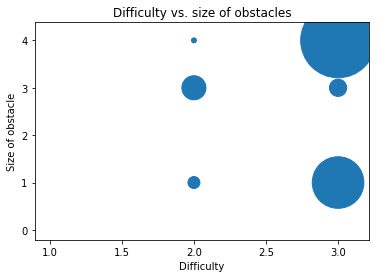

In [339]:
plt.figure()
print(conc_num.groupby(['physDifficulty','numObstacles']).size())


values = factory.get_number_of_obstacles_per_difficulty()

plt.title('Difficulty vs. size of obstacles')
plt.ylabel('Size of obstacle')
plt.xlabel('Difficulty')
x = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
y = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]
plt.scatter(x, y, s=values)
plt.savefig(gl.svn_base_path + '/Plots/corr_difficulty_numObstacles.pdf')

Difficulty level corresponds mostly to bigger obstacles

# Obstacle Information

In [340]:
# Idea: Get % of crashes per difficulty level
df = conc_dataframes

grouped2 = df.groupby(['physDifficulty', 'Logtype']).size()
print(grouped2)

print('On physDifficulty=HIGH, there were ' + str(grouped2[2]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[1]) + \
      ', i.e. ' + str(round(grouped2[1]/grouped2[2],2)) + '%.' )

print('On physDifficulty=MEDIUM, there were ' + str(grouped2[6]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[5]) + \
      ', i.e. ' + str(round(grouped2[5]/grouped2[6],2)) + '%.' )


physDifficulty  Logtype       
HIGH            CONTINUOUS        16553
                EVENT_CRASH        1749
                EVENT_OBSTACLE     8547
                EVENT_PICKUP       1511
MEDIUM          CONTINUOUS         2278
                EVENT_CRASH         178
                EVENT_OBSTACLE      749
                EVENT_PICKUP        143
dtype: int64
On physDifficulty=HIGH, there were 8547 obstacles, out of which the user crashed 1749, i.e. 0.2%.
On physDifficulty=MEDIUM, there were 749 obstacles, out of which the user crashed 178, i.e. 0.24%.


#  Scatter plot: Difficulty vs HR

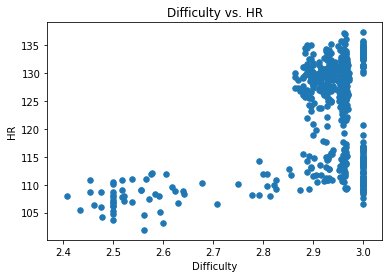

In [341]:
df = conc_with_hr
df_num = factory.transformToNumbers(df)
df_num.set_index('timedelta', inplace=True)
resolution=1
# resample and take mean over difficulty. This emans that a point can now have a difficulty "between"
# Low/Medium/High, depending on how many seconds out of the resolution seconds it was on which level.
avg_hr_df_resampled = df_num.resample(str(resolution)+'S').mean() 

plt.title('Difficulty vs. HR')
plt.ylabel('HR')
plt.xlabel('Difficulty')
x = avg_hr_df_resampled['physDifficulty']
y = avg_hr_df_resampled['Heartrate']
plt.scatter(x, y, s=30)

- Difficulty indeed has an influence on Heartrate
